<a href="https://colab.research.google.com/github/mohamed-12-4/Heart_Sound_Classification/blob/main/Heart_sound_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install PyWavelets

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import random
import scipy
from IPython.display import Audio, display
import librosa
import librosa.display
import seaborn as sns
import pandas as pd
import torch
import torchaudio
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F
import pywt

# Load data


In [ ]:
# Normal data

!wget http://istethoscope.peterjbentley.com/heartchallenge/wav/Btraining_normal.zip
!unzip Btraining_normal.zip
!rm Btraining_normal.zip
!wget http://istethoscope.peterjbentley.com/heartchallenge/Btraining_normal_seg.csv
# Mumur data
!wget http://istethoscope.peterjbentley.com/heartchallenge/wav/Btraining_murmur.zip
!unzip Btraining_murmur.zip
!rm Btraining_murmur.zip

#extrasystole
!wget http://istethoscope.peterjbentley.com/heartchallenge/wav/Btraining_extrasystole.zip
!unzip Btraining_extrasystole.zip
!rm Btraining_extrasystole.zip

--2024-08-27 12:29:30--  http://istethoscope.peterjbentley.com/heartchallenge/wav/Btraining_normal.zip
Resolving istethoscope.peterjbentley.com (istethoscope.peterjbentley.com)... 192.250.237.70
Connecting to istethoscope.peterjbentley.com (istethoscope.peterjbentley.com)|192.250.237.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13761027 (13M) [application/zip]
Saving to: ‘Btraining_normal.zip’

Btraining_normal.zi 100%[===================>]  13.12M  2.93MB/s    in 5.1s    

2024-08-27 12:29:36 (2.57 MB/s) - ‘Btraining_normal.zip’ saved [13761027/13761027]

Archive:  Btraining_normal.zip
replace Training B Normal/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Training B Normal/.DS_Store  
  inflating: __MACOSX/Training B Normal/._.DS_Store  
  inflating: Training B Normal/103_1305031931979_B.wav  
  inflating: __MACOSX/Training B Normal/._103_1305031931979_B.wav  
  inflating: Training B Normal/103_1305031931979_D1.wav  
  inflating: __MAC

In [ ]:
def split(s):
  chars = ['_', "/"]
  for c in chars:
    s = " ".join(s.split(c))
  return s.split()


In [ ]:

def load_data(dir_path):
  paths = []
  y = []

  for dirname, subdir, files in os.walk(dir_path):
    for f in files:
      if not f.endswith('.wav'):
        continue
      path = os.path.join(dirname, f)
      paths.append(path)
      y.append(split(dir_path)[-1].lower())

  df = pd.DataFrame({'path': paths, 'label': y})
  return df

normal = load_data('/content/Training B Normal')
murmur = load_data('/content/Btraining_murmur')
extrastole = load_data('/content/Btraining_extrastole')
df = pd.concat([normal, murmur, extrastole])


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df[['label']])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
classes = le.classes_

In [ ]:
classes

array(['extrastole', 'murmur', 'normal'], dtype=object)

In [ ]:
df['signal'] = df['path'].apply(lambda x: librosa.load(x)[0])

In [ ]:
type(df['signal'].iloc[1])

numpy.ndarray

In [ ]:
def fix_lenght(signal, lenght):
  if signal.shape[0] < lenght:
    signal = np.pad(signal, (0, lenght - signal.shape[0]))
  elif signal.shape[0] > lenght:
    signal = signal[:lenght]
  return signal

In [ ]:
df['signal'] = df['signal'].apply(lambda x: fix_lenght(x, 25000))

In [ ]:
df['rate'] = df['path'].apply(lambda x: librosa.load(x)[1])

In [ ]:
df['signal_lenght'] = df['signal'].apply(lambda x: x.shape[0])

In [ ]:
df

,path,label,signal,rate,signal_lenght
0,/content/Training B Normal/Btraining_noisynorm...,2,"[-0.06424696, -0.07385278, -0.076660514, -0.07...",22050,25000
1,/content/Training B Normal/208_1308159994503_C...,2,"[-0.0033779703, -0.0049561756, -0.006515392, -...",22050,25000
2,/content/Training B Normal/Btraining_noisynorm...,2,"[-0.017818699, -0.020907335, -0.02243503, -0.0...",22050,25000
3,/content/Training B Normal/168_1307970069434_A...,2,"[0.002360615, 0.0034610974, 0.0046580434, 0.00...",22050,25000
4,/content/Training B Normal/286_1311170606028_A...,2,"[-0.025364015, -0.030387467, -0.033514023, -0....",22050,25000
...,...,...,...,...,...
456,/content/Btraining_murmur/Btraining_noisymurmu...,1,"[0.032095768, 0.037791796, 0.04062595, 0.04086...",22050,25000
457,/content/Training B Normal/290_1311182875320_A...,2,"[-0.016294796, -0.01859469, -0.019159839, -0.0...",22050,25000
458,/content/Training B Normal/133_1306759619127_A...,2,"[0.009948589, 0.011807519, 0.012821878, 0.0130...",22050,25000
459,/content/Training B Normal/Btraining_noisynorm...,2,"[0.004040597, 0.0044463556, 0.004317157, 0.003...",22050,25000


In [ ]:
df['signal_lenght'].mean()

25916.04338394794

In [ ]:
class ECGDataset(torch.utils.data.Dataset):
  def __init__(self, df) -> None:
    self.df = df

    self.label = df['label']

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    data = self.df['signal'].iloc[idx]
    label = self.df['label'].iloc[idx]
    return torch.from_numpy(data), label

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
df

,path,label,signal,rate,signal_lenght
0,/content/Training B Normal/Btraining_noisynorm...,2,"[-0.0041013164, -0.0054221516, -0.006643458, -...",22050,25000
1,/content/Training B Normal/Btraining_noisynorm...,2,"[-0.0075251376, -0.009857628, -0.011796199, -0...",22050,25000
2,/content/Btraining_extrastole/215_130824566473...,0,"[-0.027716013, -0.032063324, -0.033699654, -0....",22050,25000
3,/content/Training B Normal/170_1307970562729_C...,2,"[-0.004873815, -0.004881922, -0.0040257294, -0...",22050,25000
4,/content/Btraining_extrastole/216_130824583951...,0,"[-0.002762383, -0.0032306558, -0.003466074, -0...",22050,25000
...,...,...,...,...,...
456,/content/Training B Normal/Btraining_noisynorm...,2,"[-0.018137809, -0.021215651, -0.022599794, -0....",22050,25000
457,/content/Btraining_murmur/245_1309200438094_B.wav,1,"[0.023107246, 0.02768246, 0.030218277, 0.03065...",22050,25000
458,/content/Training B Normal/146_1306778707532_B...,2,"[-0.26682383, -0.31298065, -0.3347817, -0.3347...",22050,25000
459,/content/Btraining_murmur/203_1308162026258_B.wav,1,"[-0.014908378, -0.017343957, -0.018267214, -0....",22050,25000


In [ ]:
def plot_waveform(waveform, sample_rate):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())  # Transpose and convert to numpy for plotting
    plt.title('Waveform of Heart Sound')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')


In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    figure, ax = plt.subplots()
    ax.specgram(waveform[0], Fs=sample_rate)
    figure.suptitle(title)
    figure.tight_layout()



In [ ]:
# TODO: Build the nn

# Trying MFCC

In [ ]:
mfcc = df['signal'].apply(lambda x: librosa.feature.mfcc(y=x, sr=df['rate'].iloc[0]))

In [ ]:
train, test = df[:int(len(df)*0.8)], df[int(len(df)*0.8):]

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
X = np.stack(mfcc.apply(lambda x: x.flatten()).to_list())
y = df['label']


#gbc = GradientBoostingClassifier()
#gbc.fit(X[:int(len(df)*0.8)], y[:int(len(df)*0.8)])

In [ ]:
accuracy_score(gbc.predict(X[int(len(df)*0.8):]), y[int(len(df)*0.8):])

0.7956989247311828

### initial findings:
by using mfcc for feature extraction I was able to achive nearly 80% by using Gradient Bossting trees, Ways to get a higher accuracy include:
- smapling the minority class
- one_hot encode the labels
- adjust the hyperparameters
- use neural networks


### sampling the minority class

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((768, 980), (768,), (192, 980), (192,))

In [ ]:
y_res.value_counts()

,count
label,
2,320
0,320
1,320


In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
accuracy_score(gbc.predict(X_test), y_test)

0.9427083333333334

As we can see we got a huge difference after resampling

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(estimator=GradientBoostingClassifier(), random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=GradientBoostingClassifier(), random_state=42)

In [ ]:
accuracy_score(ada.predict(X_test), y_test)

0.953125

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_ds = ECGDataset(train)
test_ds = ECGDataset(test)

### RNN

In [ ]:
df['label'].value_counts()

,count
label,
2,320
1,320
0,320


In [ ]:
df['signal']

,signal
0,"[-0.010382509, -0.0117383525, -0.012032576, -0..."
1,"[-0.026653834, -0.03114801, -0.03312645, -0.03..."
2,"[-0.0046437196, -0.0062882756, -0.007881145, -..."
3,"[0.023404034, 0.02760721, 0.029769983, 0.03010..."
4,"[0.0055779545, 0.006506115, 0.00690701, 0.0068..."
...,...
955,"[-0.0040120604, -0.004868087, -0.0054581505, -..."
956,"[-0.048050907, -0.05561978, -0.058524743, -0.0..."
957,"[0.00013719709, 0.00062448403, 0.0012244792, 0..."
958,"[-0.01050725, -0.012288787, -0.013128199, -0.0..."


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RNN(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = torch.nn.Linear(hidden_size, num_classes)

  def forward(self, x):
        # Correctly initialize the hidden state
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # (num_layers, batch_size, hidden_size)

    out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
    out = self.fc(out[:, -1, :])  # Use the last time step's output for classification
    out = self.relu(out)
    return out

In [ ]:
class LTSM(torch.nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
    super(LTSM, self).__init__()
    self.rnn = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    rnn_out, _ = self.rnn(x)
    out = self.fc(self.dropout(rnn_out[:, -1, :]))  # Use the last time step
    return out

In [ ]:
for i in train_loader:
  print(i[0][0].shape)
  break

torch.Size([25000])


Epoch 1/100: 100%|██████████| 24/24 [00:00<00:00, 35.64it/s, loss=1.69]


Epoch [1/100], Loss: 2.1842


Epoch 2/100: 100%|██████████| 24/24 [00:00<00:00, 36.12it/s, loss=1.4]


Epoch [2/100], Loss: 1.2324


Epoch 3/100: 100%|██████████| 24/24 [00:00<00:00, 36.17it/s, loss=2.31]


Epoch [3/100], Loss: 1.1089


Epoch 4/100: 100%|██████████| 24/24 [00:00<00:00, 36.89it/s, loss=2.11]


Epoch [4/100], Loss: 1.1543


Epoch 5/100: 100%|██████████| 24/24 [00:00<00:00, 36.07it/s, loss=1.32]


Epoch [5/100], Loss: 1.1174


Epoch 6/100: 100%|██████████| 24/24 [00:00<00:00, 35.98it/s, loss=1.39]


Epoch [6/100], Loss: 1.1925


Epoch 7/100: 100%|██████████| 24/24 [00:00<00:00, 36.52it/s, loss=1.48]


Epoch [7/100], Loss: 1.0670


Epoch 8/100: 100%|██████████| 24/24 [00:00<00:00, 35.84it/s, loss=1.91]


Epoch [8/100], Loss: 1.0387


Epoch 9/100: 100%|██████████| 24/24 [00:00<00:00, 35.92it/s, loss=2.85]


Epoch [9/100], Loss: 1.2067


Epoch 10/100: 100%|██████████| 24/24 [00:00<00:00, 34.78it/s, loss=2.23]


Epoch [10/100], Loss: 1.2240


Epoch 11/100: 100%|██████████| 24/24 [00:00<00:00, 35.71it/s, loss=1.8]


Epoch [11/100], Loss: 1.2685


Epoch 12/100: 100%|██████████| 24/24 [00:00<00:00, 33.03it/s, loss=2.57]


Epoch [12/100], Loss: 1.1757


Epoch 13/100: 100%|██████████| 24/24 [00:00<00:00, 34.54it/s, loss=1.18]


Epoch [13/100], Loss: 0.9916


Epoch 14/100: 100%|██████████| 24/24 [00:00<00:00, 33.93it/s, loss=1.59]


Epoch [14/100], Loss: 1.0887


Epoch 15/100: 100%|██████████| 24/24 [00:00<00:00, 34.89it/s, loss=2.41]


Epoch [15/100], Loss: 1.4001


Epoch 16/100: 100%|██████████| 24/24 [00:00<00:00, 36.01it/s, loss=1.76]


Epoch [16/100], Loss: 1.2706


Epoch 17/100: 100%|██████████| 24/24 [00:00<00:00, 36.65it/s, loss=1.82]


Epoch [17/100], Loss: 1.1491


Epoch 18/100: 100%|██████████| 24/24 [00:00<00:00, 36.19it/s, loss=2.07]


Epoch [18/100], Loss: 1.3693


Epoch 19/100: 100%|██████████| 24/24 [00:00<00:00, 35.61it/s, loss=1]


Epoch [19/100], Loss: 0.9852


Epoch 20/100: 100%|██████████| 24/24 [00:00<00:00, 35.81it/s, loss=1.38]


Epoch [20/100], Loss: 1.3374


Epoch 21/100: 100%|██████████| 24/24 [00:00<00:00, 36.06it/s, loss=1.7]


Epoch [21/100], Loss: 1.2194


Epoch 22/100: 100%|██████████| 24/24 [00:00<00:00, 35.86it/s, loss=2]


Epoch [22/100], Loss: 1.4451


Epoch 23/100: 100%|██████████| 24/24 [00:00<00:00, 37.17it/s, loss=1.17]


Epoch [23/100], Loss: 1.1736


Epoch 24/100: 100%|██████████| 24/24 [00:00<00:00, 36.03it/s, loss=1.74]


Epoch [24/100], Loss: 1.4144


Epoch 25/100: 100%|██████████| 24/24 [00:00<00:00, 36.38it/s, loss=1.35]


Epoch [25/100], Loss: 1.3417


Epoch 26/100: 100%|██████████| 24/24 [00:00<00:00, 36.62it/s, loss=0.412]


Epoch [26/100], Loss: 1.2631


Epoch 27/100: 100%|██████████| 24/24 [00:00<00:00, 36.39it/s, loss=0.175]


Epoch [27/100], Loss: 0.9346


Epoch 28/100: 100%|██████████| 24/24 [00:00<00:00, 35.99it/s, loss=1.3]


Epoch [28/100], Loss: 0.9398


Epoch 29/100: 100%|██████████| 24/24 [00:00<00:00, 36.73it/s, loss=0.988]


Epoch [29/100], Loss: 0.9084


Epoch 30/100: 100%|██████████| 24/24 [00:00<00:00, 34.57it/s, loss=0.455]


Epoch [30/100], Loss: 0.8993


Epoch 31/100: 100%|██████████| 24/24 [00:00<00:00, 35.74it/s, loss=0.917]


Epoch [31/100], Loss: 0.6482


Epoch 32/100: 100%|██████████| 24/24 [00:00<00:00, 35.94it/s, loss=0.602]


Epoch [32/100], Loss: 0.7847


Epoch 33/100: 100%|██████████| 24/24 [00:00<00:00, 34.68it/s, loss=0.000431]


Epoch [33/100], Loss: 0.5957


Epoch 34/100: 100%|██████████| 24/24 [00:00<00:00, 34.28it/s, loss=0.196]


Epoch [34/100], Loss: 0.3973


Epoch 35/100: 100%|██████████| 24/24 [00:00<00:00, 32.17it/s, loss=0.459]


Epoch [35/100], Loss: 0.4218


Epoch 36/100: 100%|██████████| 24/24 [00:00<00:00, 34.80it/s, loss=0.0425]


Epoch [36/100], Loss: 0.4739


Epoch 37/100: 100%|██████████| 24/24 [00:00<00:00, 32.94it/s, loss=0.226]


Epoch [37/100], Loss: 0.3892


Epoch 38/100: 100%|██████████| 24/24 [00:00<00:00, 35.44it/s, loss=0.536]


Epoch [38/100], Loss: 0.4366


Epoch 39/100: 100%|██████████| 24/24 [00:00<00:00, 35.31it/s, loss=0.372]


Epoch [39/100], Loss: 0.4764


Epoch 40/100: 100%|██████████| 24/24 [00:00<00:00, 35.42it/s, loss=0.524]


Epoch [40/100], Loss: 0.2889


Epoch 41/100: 100%|██████████| 24/24 [00:00<00:00, 35.81it/s, loss=0.00625]


Epoch [41/100], Loss: 0.3612


Epoch 42/100: 100%|██████████| 24/24 [00:00<00:00, 36.12it/s, loss=0.511]


Epoch [42/100], Loss: 0.3038


Epoch 43/100: 100%|██████████| 24/24 [00:00<00:00, 35.78it/s, loss=0.367]


Epoch [43/100], Loss: 0.3752


Epoch 44/100: 100%|██████████| 24/24 [00:00<00:00, 36.00it/s, loss=0.193]


Epoch [44/100], Loss: 0.2932


Epoch 45/100: 100%|██████████| 24/24 [00:00<00:00, 35.84it/s, loss=0.00246]


Epoch [45/100], Loss: 0.2463


Epoch 46/100: 100%|██████████| 24/24 [00:00<00:00, 35.87it/s, loss=0.000202]


Epoch [46/100], Loss: 0.2734


Epoch 47/100: 100%|██████████| 24/24 [00:00<00:00, 35.74it/s, loss=0.165]


Epoch [47/100], Loss: 0.2306


Epoch 48/100: 100%|██████████| 24/24 [00:00<00:00, 36.22it/s, loss=0.324]


Epoch [48/100], Loss: 0.2455


Epoch 49/100: 100%|██████████| 24/24 [00:00<00:00, 35.39it/s, loss=0.199]


Epoch [49/100], Loss: 0.1454


Epoch 50/100: 100%|██████████| 24/24 [00:00<00:00, 34.48it/s, loss=0.585]


Epoch [50/100], Loss: 0.2324


Epoch 51/100: 100%|██████████| 24/24 [00:00<00:00, 34.28it/s, loss=0.314]


Epoch [51/100], Loss: 0.2130


Epoch 52/100: 100%|██████████| 24/24 [00:00<00:00, 34.56it/s, loss=0.00254]


Epoch [52/100], Loss: 0.1915


Epoch 53/100: 100%|██████████| 24/24 [00:00<00:00, 34.13it/s, loss=0.577]


Epoch [53/100], Loss: 0.2076


Epoch 54/100: 100%|██████████| 24/24 [00:00<00:00, 35.01it/s, loss=0.00055]


Epoch [54/100], Loss: 0.2111


Epoch 55/100: 100%|██████████| 24/24 [00:00<00:00, 35.20it/s, loss=0.037]


Epoch [55/100], Loss: 0.1765


Epoch 56/100: 100%|██████████| 24/24 [00:00<00:00, 34.48it/s, loss=0.182]


Epoch [56/100], Loss: 0.1156


Epoch 57/100: 100%|██████████| 24/24 [00:00<00:00, 35.80it/s, loss=9.36e-5]


Epoch [57/100], Loss: 0.1510


Epoch 58/100: 100%|██████████| 24/24 [00:00<00:00, 36.61it/s, loss=0.211]


Epoch [58/100], Loss: 0.2393


Epoch 59/100: 100%|██████████| 24/24 [00:00<00:00, 35.81it/s, loss=0.652]


Epoch [59/100], Loss: 0.1895


Epoch 60/100: 100%|██████████| 24/24 [00:00<00:00, 35.95it/s, loss=0.465]


Epoch [60/100], Loss: 0.2748


Epoch 61/100: 100%|██████████| 24/24 [00:00<00:00, 36.10it/s, loss=0.0588]


Epoch [61/100], Loss: 0.1065


Epoch 62/100: 100%|██████████| 24/24 [00:00<00:00, 35.79it/s, loss=0.196]


Epoch [62/100], Loss: 0.1967


Epoch 63/100: 100%|██████████| 24/24 [00:00<00:00, 35.83it/s, loss=0.179]


Epoch [63/100], Loss: 0.1737


Epoch 64/100: 100%|██████████| 24/24 [00:00<00:00, 35.95it/s, loss=0.35]


Epoch [64/100], Loss: 0.1865


Epoch 65/100: 100%|██████████| 24/24 [00:00<00:00, 35.63it/s, loss=0.00197]


Epoch [65/100], Loss: 0.0887


Epoch 66/100: 100%|██████████| 24/24 [00:00<00:00, 35.99it/s, loss=0.175]


Epoch [66/100], Loss: 0.2039


Epoch 67/100: 100%|██████████| 24/24 [00:00<00:00, 36.22it/s, loss=0.00552]


Epoch [67/100], Loss: 0.1322


Epoch 68/100: 100%|██████████| 24/24 [00:00<00:00, 35.75it/s, loss=0.242]


Epoch [68/100], Loss: 0.2292


Epoch 69/100: 100%|██████████| 24/24 [00:00<00:00, 35.99it/s, loss=0.0374]


Epoch [69/100], Loss: 0.1170


Epoch 70/100: 100%|██████████| 24/24 [00:00<00:00, 36.06it/s, loss=0.17]


Epoch [70/100], Loss: 0.1880


Epoch 71/100: 100%|██████████| 24/24 [00:00<00:00, 34.83it/s, loss=0.0867]


Epoch [71/100], Loss: 0.1254


Epoch 72/100: 100%|██████████| 24/24 [00:00<00:00, 34.44it/s, loss=2.81e-5]


Epoch [72/100], Loss: 0.1790


Epoch 73/100: 100%|██████████| 24/24 [00:00<00:00, 33.83it/s, loss=0.467]


Epoch [73/100], Loss: 0.0799


Epoch 74/100: 100%|██████████| 24/24 [00:00<00:00, 34.76it/s, loss=0.00191]


Epoch [74/100], Loss: 0.1053


Epoch 75/100: 100%|██████████| 24/24 [00:00<00:00, 34.13it/s, loss=0.181]


Epoch [75/100], Loss: 0.1474


Epoch 76/100: 100%|██████████| 24/24 [00:00<00:00, 35.73it/s, loss=0.0804]


Epoch [76/100], Loss: 0.1365


Epoch 77/100: 100%|██████████| 24/24 [00:00<00:00, 36.01it/s, loss=0.0134]


Epoch [77/100], Loss: 0.1848


Epoch 78/100: 100%|██████████| 24/24 [00:00<00:00, 35.48it/s, loss=0.0103]


Epoch [78/100], Loss: 0.1314


Epoch 79/100: 100%|██████████| 24/24 [00:00<00:00, 35.59it/s, loss=0.142]


Epoch [79/100], Loss: 0.1230


Epoch 80/100: 100%|██████████| 24/24 [00:00<00:00, 35.26it/s, loss=0.423]


Epoch [80/100], Loss: 0.1360


Epoch 81/100: 100%|██████████| 24/24 [00:00<00:00, 34.77it/s, loss=0.0561]


Epoch [81/100], Loss: 0.1235


Epoch 82/100: 100%|██████████| 24/24 [00:00<00:00, 34.89it/s, loss=0.602]


Epoch [82/100], Loss: 0.2667


Epoch 83/100: 100%|██████████| 24/24 [00:00<00:00, 34.41it/s, loss=0.306]


Epoch [83/100], Loss: 0.1505


Epoch 84/100: 100%|██████████| 24/24 [00:00<00:00, 35.31it/s, loss=0.148]


Epoch [84/100], Loss: 0.2045


Epoch 85/100: 100%|██████████| 24/24 [00:00<00:00, 35.47it/s, loss=0.0236]


Epoch [85/100], Loss: 0.2381


Epoch 86/100: 100%|██████████| 24/24 [00:00<00:00, 35.27it/s, loss=0.0107]


Epoch [86/100], Loss: 0.2158


Epoch 87/100: 100%|██████████| 24/24 [00:00<00:00, 35.17it/s, loss=0.00012]


Epoch [87/100], Loss: 0.1160


Epoch 88/100: 100%|██████████| 24/24 [00:00<00:00, 34.99it/s, loss=0.0305]


Epoch [88/100], Loss: 0.1495


Epoch 89/100: 100%|██████████| 24/24 [00:00<00:00, 35.06it/s, loss=0.0122]


Epoch [89/100], Loss: 0.1825


Epoch 90/100: 100%|██████████| 24/24 [00:00<00:00, 34.94it/s, loss=0.467]


Epoch [90/100], Loss: 0.1183


Epoch 91/100: 100%|██████████| 24/24 [00:00<00:00, 33.65it/s, loss=0.538]


Epoch [91/100], Loss: 0.1365


Epoch 92/100: 100%|██████████| 24/24 [00:00<00:00, 33.05it/s, loss=0.409]


Epoch [92/100], Loss: 0.2320


Epoch 93/100: 100%|██████████| 24/24 [00:00<00:00, 31.88it/s, loss=0.00454]


Epoch [93/100], Loss: 0.1406


Epoch 94/100: 100%|██████████| 24/24 [00:00<00:00, 32.52it/s, loss=0.00141]


Epoch [94/100], Loss: 0.1301


Epoch 95/100: 100%|██████████| 24/24 [00:00<00:00, 33.62it/s, loss=0.00244]


Epoch [95/100], Loss: 0.1950


Epoch 96/100: 100%|██████████| 24/24 [00:00<00:00, 35.26it/s, loss=0.189]


Epoch [96/100], Loss: 0.1029


Epoch 97/100: 100%|██████████| 24/24 [00:00<00:00, 35.58it/s, loss=0.0529]


Epoch [97/100], Loss: 0.1177


Epoch 98/100: 100%|██████████| 24/24 [00:00<00:00, 35.13it/s, loss=0.000152]


Epoch [98/100], Loss: 0.1964


Epoch 99/100: 100%|██████████| 24/24 [00:00<00:00, 34.39it/s, loss=3.17e-6]


Epoch [99/100], Loss: 0.1343


Epoch 100/100: 100%|██████████| 24/24 [00:00<00:00, 35.56it/s, loss=1.43e-6]


Epoch [100/100], Loss: 0.1267


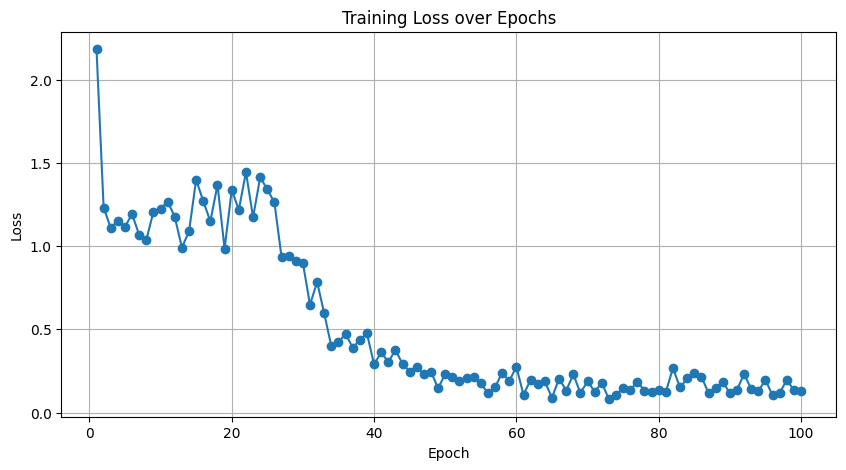

In [ ]:
# training loop
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.1

NUM_CLASS = 3
INPUT_SIZE = 25000
HIDDEN_SIZE = 256
NUM_LAYERS = 2

model = LTSM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASS).to(device)


train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

# Assuming the model, dataset, and DataLoader are defined as before

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)
# Training loop
train_losses = []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Use tqdm to create a progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{EPOCHS}')

    for i, (inputs, labels) in progress_bar:
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Store the average loss for this epoch
    scheduler.step(running_loss)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}')

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assuming 'test_loader' is your DataLoader for the test dataset

def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Ensure inputs have 3 dimensions (batch_size, seq_length, input_size)
            if inputs.dim() == 2:
                inputs = inputs.unsqueeze(1)  # Add sequence length dimension

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
    return accuracy

# Evaluate the model on the test dataset
accuracy = evaluate_model(model, test_loader, device)


Evaluating: 100%|██████████| 3/3 [00:00<00:00, 27.74it/s]

Accuracy on the test set: 71.35%


In [ ]:
accuracy

0.84375

In [ ]:
df

,signal,label
0,"[-0.010382509, -0.0117383525, -0.012032576, -0...",2
1,"[-0.026653834, -0.03114801, -0.03312645, -0.03...",2
2,"[-0.0046437196, -0.0062882756, -0.007881145, -...",2
3,"[0.023404034, 0.02760721, 0.029769983, 0.03010...",2
4,"[0.0055779545, 0.006506115, 0.00690701, 0.0068...",2
...,...,...
955,"[-0.0040120604, -0.004868087, -0.0054581505, -...",1
956,"[-0.048050907, -0.05561978, -0.058524743, -0.0...",1
957,"[0.00013719709, 0.00062448403, 0.0012244792, 0...",1
958,"[-0.01050725, -0.012288787, -0.013128199, -0.0...",1


### RNN w/MFCC

In [ ]:
#sm = SMOTE(random_state=42)
#df = df.sample(frac=1).reset_index(drop=True)

#mfcc = df['signal'].apply(lambda x: librosa.feature.mfcc(y=x, sr=df['rate'].iloc[0]))
class MFCCDataset(torch.utils.data.Dataset):
  def __init__(self, X, y) -> None:
    assert len(X) == len(y), "X and y must have the same length"
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return torch.from_numpy(self.X[idx]), self.y.iloc[idx]

X = np.stack(mfcc.apply(lambda x: x.flatten()))
y = df['label']

X_res, y_res = sm.fit_resample(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
X_test.shape

(192, 980)

In [ ]:
train_ds = MFCCDataset(X_train, y_train)
test_ds = MFCCDataset(X_test, y_test)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
class MFCC_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.5):
        super(MFCC_RNN, self).__init__()

        self.c1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.p1 = nn.MaxPool1d(kernel_size=2)

        self.c2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.p2 = nn.MaxPool1d(kernel_size=2)

        self.c3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.p3 = nn.MaxPool1d(kernel_size=2)


        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size=round(input_size/8),
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True,
                            dropout=dropout)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.LeakyReLU()

        # Fully connected layer to map to output classes
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional



    def forward(self, x):
        # Apply 1D convolution
        x = self.c1(x)
        x = self.relu(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.relu(x)
        x = self.p2(x)
        x = self.c3(x)
        x = self.relu(x)
        x = self.p3(x)

        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_len, hidden_size*2)

        # Use the last output of the LSTM (many-to-one)
        lstm_out = lstm_out[:, -1, :]  # shape: (batch_size, hidden_size*2)

        # Apply ReLU activation
        lstm_out = self.relu(lstm_out)

        # Output layer
        out = self.fc(lstm_out)  # shape: (batch_size, output_size)

        return out


In [ ]:
mfcc

,signal
0,"[[-439.8929, -451.76, -466.11154, -461.901, -4..."
1,"[[-418.9721, -395.43814, -394.32526, -402.7609..."
2,"[[-363.84598, -382.02884, -362.52203, -331.263..."
3,"[[-142.75436, -195.95215, -340.94705, -336.893..."
4,"[[-170.45073, -199.37218, -275.24265, -273.716..."
...,...
456,"[[-303.4474, -315.1346, -327.50052, -337.75165..."
457,"[[-449.75806, -436.14832, -434.06586, -432.283..."
458,"[[-518.0232, -506.94022, -501.83932, -492.6589..."
459,"[[-450.55975, -428.11496, -422.26074, -416.088..."


In [ ]:
# training loop
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


device = 'cuda' if torch.cuda.is_available() else 'cpu'

EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 0.001

NUM_CLASS = 3
INPUT_SIZE = 980
HIDDEN_SIZE = 256
NUM_LAYERS = 2

model = MFCC_RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASS, NUM_LAYERS).to(device)


train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))
# Assuming the model, dataset, and DataLoader are defined as before

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.0001, patience=2, verbose=True)
# Training loop
train_losses = []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Use tqdm to create a progress bar
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{EPOCHS}')

    for i, (inputs, labels) in progress_bar:
        # Move tensors to the configured device
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm with the current loss
        progress_bar.set_postfix(loss=loss.item())

    # Store the average loss for this epoch
    scheduler.step(running_loss)
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}')

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


12


Epoch 1/200: 100%|██████████| 12/12 [00:00<00:00, 16.50it/s, loss=1.03]


Epoch [1/200], Loss: 1.0750


Epoch 2/200: 100%|██████████| 12/12 [00:00<00:00, 17.61it/s, loss=0.852]


Epoch [2/200], Loss: 0.9675


Epoch 3/200: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s, loss=0.837]


Epoch [3/200], Loss: 0.8901


Epoch 4/200: 100%|██████████| 12/12 [00:00<00:00, 17.54it/s, loss=0.966]


Epoch [4/200], Loss: 0.8674


Epoch 5/200: 100%|██████████| 12/12 [00:00<00:00, 17.66it/s, loss=0.766]


Epoch [5/200], Loss: 0.8327


Epoch 6/200: 100%|██████████| 12/12 [00:00<00:00, 17.74it/s, loss=0.811]


Epoch [6/200], Loss: 0.8100


Epoch 7/200: 100%|██████████| 12/12 [00:00<00:00, 17.59it/s, loss=0.736]


Epoch [7/200], Loss: 0.7681


Epoch 8/200: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s, loss=0.525]


Epoch [8/200], Loss: 0.6657


Epoch 9/200: 100%|██████████| 12/12 [00:00<00:00, 17.36it/s, loss=0.919]


Epoch [9/200], Loss: 0.6866


Epoch 10/200: 100%|██████████| 12/12 [00:00<00:00, 17.56it/s, loss=0.488]


Epoch [10/200], Loss: 0.5756


Epoch 11/200: 100%|██████████| 12/12 [00:00<00:00, 17.55it/s, loss=0.45]


Epoch [11/200], Loss: 0.5116


Epoch 12/200: 100%|██████████| 12/12 [00:00<00:00, 17.61it/s, loss=0.276]


Epoch [12/200], Loss: 0.3803


Epoch 13/200: 100%|██████████| 12/12 [00:00<00:00, 17.52it/s, loss=0.263]


Epoch [13/200], Loss: 0.3471


Epoch 14/200: 100%|██████████| 12/12 [00:00<00:00, 17.38it/s, loss=0.368]


Epoch [14/200], Loss: 0.2814


Epoch 15/200: 100%|██████████| 12/12 [00:00<00:00, 17.47it/s, loss=0.168]


Epoch [15/200], Loss: 0.2044


Epoch 16/200:  50%|█████     | 6/12 [00:00<00:00, 15.08it/s, loss=0.23]


KeyboardInterrupt: 

In [ ]:
evaluate_model(model, test_loader, device)

Evaluating: 100%|██████████| 3/3 [00:00<00:00, 32.62it/s]

Accuracy on the test set: 86.98%


0.8697916666666666

In [ ]:
model(torch.from_numpy(X_test).unsqueeze(1).to(device))

tensor([[-4.4154,  3.4105, -0.5169],
        [ 3.5470, -4.3647,  0.0927],
        [-3.1127,  3.2700, -1.1416],
        [-1.1843,  0.9363, -0.5915],
        [-5.1925,  5.3880, -1.8999],
        [ 2.6205, -2.0457, -1.0651],
        [-1.1063, -0.3852,  0.8066],
        [-2.1675,  2.4241, -1.0104],
        [-3.1800, -0.9300,  3.3903],
        [-3.3969,  3.9290, -1.7588],
        [ 1.3735, -2.2669,  0.2364],
        [-0.4496, -1.9012,  1.7953],
        [-2.1358, -2.0183,  3.7178],
        [-2.5396,  2.1815, -0.4423],
        [ 4.1818, -4.3388, -0.6366],
        [ 4.0133, -4.0794, -0.7465],
        [ 0.4323, -3.8568,  2.7850],
        [ 3.7162, -3.5821, -0.9302],
        [-4.5947,  3.1769,  0.0331],
        [-5.0585,  3.4157,  0.3303],
        [-4.9494,  3.1355,  0.4687],
        [-0.8993, -0.8649,  1.0750],
        [-5.1206,  2.2866,  1.4336],
        [-4.4234,  3.6452, -0.5279],
        [ 4.1378, -4.0885, -0.8606],
        [ 2.4895, -4.3548,  1.2606],
        [-3.4078, -0.1902,  2.7130],
 

In [ ]:
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn.functional as F

# Define the RNN model (assuming it’s already trained)
class RNNModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, rnn_model):
        self.rnn_model = rnn_model

    def fit(self, X, y=None):
      return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.rnn_model(X_tensor)
            _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def predict_proba(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)
        with torch.no_grad():
            outputs = self.rnn_model(X_tensor)
            probabilities = F.softmax(outputs, dim=1)
        return probabilities.cpu().numpy()

# Instantiate your models (ensure they are trained)
nn_model = RNNModelWrapper(model)


voting_clf = VotingClassifier(
    estimators=[
        ('gboost', gbc),
        ('adaboost', ada),
        ('rnn', nn_model)
    ],
    voting='soft'  # Use 'hard' for hard voting
)

# Fit the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate the voting classifier
accuracy = voting_clf.score(X_test, y_test)
print(f'Voting Classifier Accuracy: {accuracy * 100:.2f}%')


Voting Classifier Accuracy: 93.23%


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [ ]:
accuracy